<a href="https://colab.research.google.com/github/mirkodelmoro25/Stereo-Vision-3D-Object-Reconstruction/blob/main/stereo_vision_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [ ]:
import os
import cv2
import glob
import copy
import numpy as np
import open3d as o3d
from matplotlib import pyplot as plt

CALIBRATION_IMAGES = 20
REDUCE_FACTOR = 3
voxel_size = 0.015

In [ ]:
try:
    from google.colab import drive

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("We're running Colab")
    # Mount the Google Drive at mount
    mount = '/content/gdrive'
    print("Colab: mounting Google drive on ", mount)
    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    drive_root = mount + "/My Drive/ComputerVision/"

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
        print("\nColab: making sure ", drive_root, " exists.")
        os.makedirs(drive_root, exist_ok=True)

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/My Drive/ComputerVision/  exists.


##Acquiring the left and right calibration images 

In [ ]:
calib_path = drive_root + 'final/calib/'
obj_path = drive_root + 'final/obj_closer/'
img_namesL = [calib_path +"left/IMG_0" + str(i) + ".JPG"  for i in range (924,944)]
img_namesR = [calib_path +"right/IMG_" + str(i) + ".JPG"  for i in range (1601,1621)]


print(img_namesL)
print(len(img_namesL), len(img_namesR))

['/content/gdrive/My Drive/ComputerVision/final/calib/left/IMG_0924.JPG', '/content/gdrive/My Drive/ComputerVision/final/calib/left/IMG_0925.JPG', '/content/gdrive/My Drive/ComputerVision/final/calib/left/IMG_0926.JPG', '/content/gdrive/My Drive/ComputerVision/final/calib/left/IMG_0927.JPG', '/content/gdrive/My Drive/ComputerVision/final/calib/left/IMG_0928.JPG', '/content/gdrive/My Drive/ComputerVision/final/calib/left/IMG_0929.JPG', '/content/gdrive/My Drive/ComputerVision/final/calib/left/IMG_0930.JPG', '/content/gdrive/My Drive/ComputerVision/final/calib/left/IMG_0931.JPG', '/content/gdrive/My Drive/ComputerVision/final/calib/left/IMG_0932.JPG', '/content/gdrive/My Drive/ComputerVision/final/calib/left/IMG_0933.JPG', '/content/gdrive/My Drive/ComputerVision/final/calib/left/IMG_0934.JPG', '/content/gdrive/My Drive/ComputerVision/final/calib/left/IMG_0935.JPG', '/content/gdrive/My Drive/ComputerVision/final/calib/left/IMG_0936.JPG', '/content/gdrive/My Drive/ComputerVision/final/cal

In [ ]:
def downsample_image(image, reduce_factor):
	for i in range(0,reduce_factor):
		#Check if image is color or grayscale
		if len(image.shape) > 2:
			row,col = image.shape[:2]
		else:
			row,col = image.shape

		image = cv2.pyrDown(image, dstsize= (col//2, row // 2))
	return image

##Read images and find 2D coordinates

In [ ]:
pattern_size = (6,8) #number of inner corners

In [ ]:
def process_image (image, last):
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    downsample_img = downsample_image(img,REDUCE_FACTOR)
    if downsample_img is None:
        print("Failed to load", image)
        return None
    found, corners = cv2.findChessboardCorners(downsample_img, pattern_size)
    if found:
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        cv2.cornerSubPix(downsample_img, corners, (5, 5), (-1, -1), term)
        if last==CALIBRATION_IMAGES-1:  #CAMBIA NOME DELLE IMMAGINI CON RE.SUB E STAMPA SOLO L'ULTIMA
            vis = cv2.cvtColor(downsample_img, cv2.COLOR_GRAY2BGR)
            cv2.drawChessboardCorners(vis, pattern_size, corners, found)
            plt.figure(figsize=(20,10))
            plt.imshow(vis)
            plt.show()
    else:
        print('chessboard not found')
        return None
    return (corners.reshape(-1, 2), pattern_points)

In [ ]:
square_size = 30 #mm
indices = np.indices(pattern_size, dtype=np.float32)*square_size
coords_3D = np.transpose(indices, [2, 1, 0])
coords_3D = coords_3D.reshape(-1, 2)

pattern_points = np.concatenate([coords_3D, np.zeros([coords_3D.shape[0], 1], dtype=np.float32)], axis=-1)

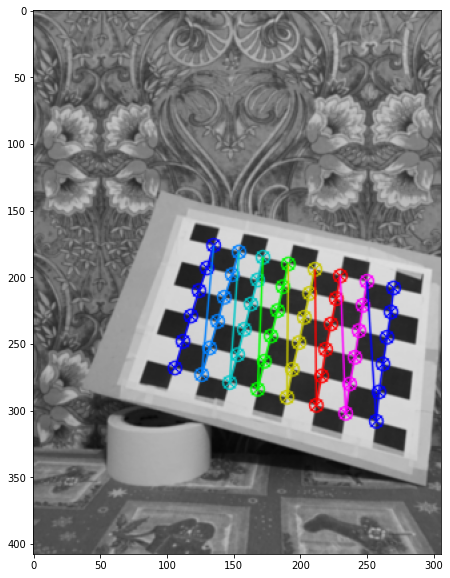

In [ ]:
chessboards_l = [process_image(last, i) for i, last in enumerate(img_namesL)]

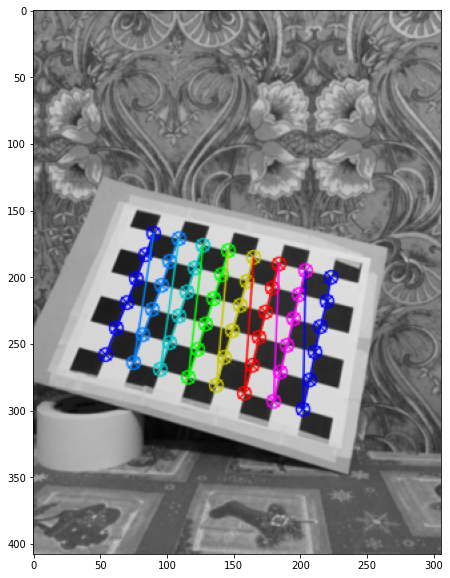

In [ ]:
chessboards_r = [process_image(last, i) for i, last in enumerate(img_namesR)]

In [ ]:
left_chessboards = [x for x in chessboards_l if x is not None]
print("Number of images from left camera where we could not detect all the corners: ", len(chessboards_l)- len(left_chessboards))
right_chessboards = [x for x in chessboards_r if x is not None]
print("Number of images from right camera where we could not detect all the corners: ", len(chessboards_r)- len(right_chessboards))

Number of images from left camera where we could not detect all the corners:  0
Number of images from right camera where we could not detect all the corners:  0


##2D-3D Correspondences

In [ ]:
obj_points = []
img_pointsL = []
img_pointsR = []

for (corners, pattern_points) in left_chessboards:
    img_pointsL.append(corners)
    obj_points.append(pattern_points)

for (corners, pattern_points) in right_chessboards:
    img_pointsR.append(corners)

##Calibration of the two cameras

In [ ]:
img = cv2.imread(img_namesL[0], cv2.IMREAD_GRAYSCALE)
h,w = downsample_image(img,REDUCE_FACTOR).shape[:2]

In [ ]:
rmsL, camera_matrixL, dist_coefsL, rvecsL, tvecsL = cv2.calibrateCamera(obj_points, img_pointsL, (w, h), None, None)
print("Left camera parameters:")
print("\nRMS:", rmsL)
'''print("camera matrix:\n", camera_matrixL)
print("distortion coefficients: ", dist_coefsL.ravel())
print("Rotation vectors:", rvecsL)
print("translation vectors", tvecsL)'''

'''#saving parameters
cv_file = cv2.FileStorage(drive_root + "final/data/left_camera.xml", cv2.FILE_STORAGE_WRITE)
cv_file.write("Left_Root_Mean_Square_Error",rmsL)
cv_file.write("Left_Camera_Matrix",camera_matrixL)
cv_file.write("Left_Distortion_Coefficients",dist_coefsL)
cv_file.release()'''

Left camera parameters:

RMS: 0.08189238840783984


'#saving parameters\ncv_file = cv2.FileStorage(drive_root + "final/data/left_camera.xml", cv2.FILE_STORAGE_WRITE)\ncv_file.write("Left_Root_Mean_Square_Error",rmsL)\ncv_file.write("Left_Camera_Matrix",camera_matrixL)\ncv_file.write("Left_Distortion_Coefficients",dist_coefsL)\ncv_file.release()'

In [ ]:
rmsR, camera_matrixR, dist_coefsR, rvecsR, tvecsR = cv2.calibrateCamera(obj_points, img_pointsR, (w, h), None, None)
print("Right camera parameters:")
print("\nRMS:", rmsR)
'''print("camera matrix:\n", camera_matrixR)
print("distortion coefficients: ", dist_coefsR.ravel())
print("Rotation vectors:", rvecsR)
print("translation vectors", tvecsR)'''

#saving parameters
#cv_file = cv2.FileStorage(drive_root + "pin/right_camera.xml", cv2.FILE_STORAGE_WRITE)
#cv_file.write("Right_Root_Mean_Square_Error",rmsR)
#cv_file.write("Right_Camera_Matrix",camera_matrixR)
#cv_file.write("Right_Distortion_Coefficients",dist_coefsR)
#cv_file.release()

Right camera parameters:

RMS: 0.08284217001250557


'print("camera matrix:\n", camera_matrixR)\nprint("distortion coefficients: ", dist_coefsR.ravel())\nprint("Rotation vectors:", rvecsR)\nprint("translation vectors", tvecsR)'

##Stereo Camera Calibration 

In [ ]:
flags = 0
flags |= cv2.CALIB_USE_INTRINSIC_GUESS

criteria_stereo= (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


ret_stereo, intrinsicsL, distL, intrinsicsR, distR, r, t, e, f = cv2.stereoCalibrate(obj_points, img_pointsL, img_pointsR, camera_matrixL, dist_coefsL, camera_matrixR, dist_coefsR, [h,w], criteria_stereo, flags)


In [ ]:
print(ret_stereo)

0.08793846004163615


In [ ]:
print('Intrinsic_mtx_1', intrinsicsL)
print('dist_1', distL)
print('Intrinsic_mtx_2', intrinsicsR)
print('dist_2', distR)
print('R', r)
print('T', t)
print('E', e)
print('F', f)

'''#saving parameters
cv_file = cv2.FileStorage(drive_root + "pin/stereo_calibration.xml", cv2.FILE_STORAGE_WRITE)
cv_file.write("Right_Root_Mean_Square_Error",ret_stereo)
cv_file.write("Rotation_Between_Cameras",r)
cv_file.write("Translation_Between_Cameras",t)
cv_file.write("Essential_Matrix",e)
cv_file.write("Fundamental_Matrix",f)
cv_file.release()'''

Intrinsic_mtx_1 [[349.42373853   0.         155.66060936]
 [  0.         349.43966039 205.27514861]
 [  0.           0.           1.        ]]
dist_1 [[-5.47881126e-03  6.28566195e-01 -6.12941466e-04  5.28268000e-03
  -1.86334077e+00]]
Intrinsic_mtx_2 [[357.34422328   0.         154.8703034 ]
 [  0.         355.97575792 199.55211478]
 [  0.           0.           1.        ]]
dist_2 [[-4.13377466e-03  6.39005162e-01 -8.46309858e-04  3.60017851e-03
  -2.10106976e+00]]
R [[ 0.99989218 -0.00731128  0.01273439]
 [ 0.00747623  0.99988814 -0.01295395]
 [-0.01263826  0.01304776  0.999835  ]]
T [[-75.63044363]
 [  1.5338401 ]
 [  8.41464686]]
E [[ -0.08229487  -8.39369245   1.64258994]
 [  7.45790257   0.92528599  75.72512014]
 [ -2.09910504 -75.6107696    0.9601805 ]]
F [[-2.08257420e-07 -2.12403165e-05  5.84500367e-03]
 [ 1.89457049e-05  2.35044590e-06  6.37865439e-02]
 [-5.64663181e-03 -6.55515534e-02  1.00000000e+00]]


'#saving parameters\ncv_file = cv2.FileStorage(drive_root + "pin/stereo_calibration.xml", cv2.FILE_STORAGE_WRITE)\ncv_file.write("Right_Root_Mean_Square_Error",ret_stereo)\ncv_file.write("Rotation_Between_Cameras",r)\ncv_file.write("Translation_Between_Cameras",t)\ncv_file.write("Essential_Matrix",e)\ncv_file.write("Fundamental_Matrix",f)\ncv_file.release()'

In [ ]:
camera_model = dict([('Intrinsic Left', intrinsicsL), ('Intrinsic Right', intrinsicsR), ('Lens Distortion Left', distL),
                            ('Lens Distortion Right', distR), ('Rotations Left Camera', rvecsL),
                            ('Rotation Right Camera', rvecsR), ('Rotation between the 2 cameras', r), ('Translation between the 2 cameras', t),
                            ('Essential Marix', e), ('Fundamental Matrix', f)])

##Stereo Rectification

In [ ]:
new_camera_matrixL, roiL = cv2.getOptimalNewCameraMatrix(camera_matrixL, dist_coefsL, (w, h), 0, (w, h))
new_camera_matrixR, roiR = cv2.getOptimalNewCameraMatrix(camera_matrixR, dist_coefsR, (w, h), 0, (w, h))

In [ ]:
rectL, rectR, projL, projR, Q, roi_left, roi_right= cv2.stereoRectify(new_camera_matrixL, distL, new_camera_matrixR, distR, [w,h], r, t, flags,alpha=0)

In [ ]:
'''#saving parameters
cv_file = cv2.FileStorage(drive_root + "final/data/intrinsic.xml", cv2.FILE_STORAGE_WRITE)
cv_file.write("Camera_MatrixL",projL)
cv_file.release()'''

In [ ]:
mapxL, mapyL= cv2.initUndistortRectifyMap(camera_matrixL, distL, rectL, projL, [w,h], cv2.CV_32FC1)
mapxR, mapyR = cv2.initUndistortRectifyMap(camera_matrixR, distR, rectR, projR, [w,h], cv2.CV_32FC1)

In [ ]:
'''#saving parameters
cv_file = cv2.FileStorage(drive_root + "final/data/stereo_rectification.xml", cv2.FILE_STORAGE_WRITE)
cv_file.write("Left_Stereo_Map_x",mapxL)
cv_file.write("Left_Stereo_Map_y",mapyL)
cv_file.write("Right_Stereo_Map_x",mapxR)
cv_file.write("Right_Stereo_Map_y",mapyR)
cv_file.write("Q",Q)
cv_file.release()'''

In [ ]:
def draw_images(imgL, imgR):
    imageL = imgL.copy()
    imageR = imgR.copy()
    for i in range(10, h, 30):
                cv2.line(imageL, (0, i), (w, i), (255, 0, 0), 2)
                cv2.line(imageR, (0, i), (w, i), (255, 0, 0), 2)

    # create unique image corresponding to the alignment of left and right
    aligned = np.hstack((imageL, imageR))
    plt.imshow(cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB))
    plt.show()
    return aligned

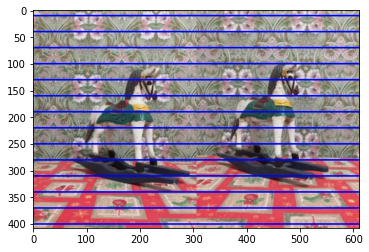

True

In [ ]:
imageL = cv2.imread(drive_root+"final/obj_closer/left/IMG_1060.JPG")
imageR = cv2.imread(drive_root+"final/obj_closer/right/IMG_1736.JPG")
h,w = downsample_image(imageL,REDUCE_FACTOR).shape[:2]
imgL = downsample_image(imageL,REDUCE_FACTOR)
imgR = downsample_image(imageR,REDUCE_FACTOR)

no_rect = draw_images(imgL, imgR)
#cv2.imwrite(drive_root+'final/paper_imgs/no_rect.png', no_rect)

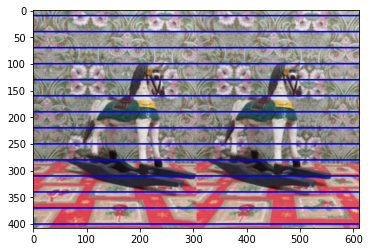

True

In [ ]:
im_rectifiedL = cv2.remap(imgL, mapxL, mapyL, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
im_rectifiedR = cv2.remap(imgR, mapxR, mapyR, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
rect = draw_images(im_rectifiedL, im_rectifiedR)
cv2.imwrite(drive_root+'final/paper_imgs/rectified_left.JPG', im_rectifiedL)
cv2.imwrite(drive_root+'final/paper_imgs/rectified_right.JPG', im_rectifiedR)
#cv2.imwrite(drive_root+'final/paper_imgs/rect.png', rect)

##Find the Disparity Map for each pair of images


Computing the disparity  map...


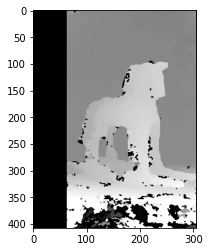

True

In [ ]:
win_size = 7 
min_disp = -1 
max_disp = 63 
num_disp = max_disp - min_disp 
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
	numDisparities = num_disp,
	blockSize = 5, 
	uniquenessRatio = 10, 
	speckleWindowSize = 5, 
	speckleRange = 100, 
	disp12MaxDiff = 25, 
	P1 = 8*3*win_size**2,
	P2 =32*3*win_size**2) 

#Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(im_rectifiedL, im_rectifiedR)
disparity_map = cv2.normalize(disparity_map, None, alpha=0, beta=255,
                              norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.imshow(disparity_map, 'gray')
plt.show()
cv2.imwrite(drive_root+'final/paper_imgs/disp.png', disparity_map)

##Background Disparity Map

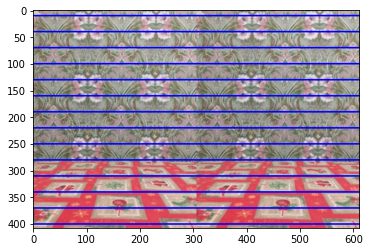

In [ ]:
bgL = cv2.imread(obj_path + "left/IMG_1075.JPG")
bgR = cv2.imread(obj_path + "right/IMG_1751.JPG")
downsample_bgL = downsample_image(bgL,REDUCE_FACTOR)
downsample_bgR = downsample_image(bgR,REDUCE_FACTOR)

bg_norect = draw_images(downsample_bgL, downsample_bgL)

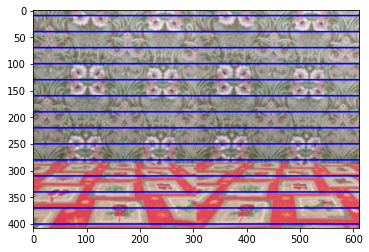

In [ ]:
bg_rectifiedL = cv2.remap(downsample_bgL, mapxL, mapyL, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
bg_rectifiedR = cv2.remap(downsample_bgR, mapxR, mapyR, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
bg_rect = draw_images(bg_rectifiedL, bg_rectifiedR)
#cv2.imwrite(drive_root+'final/imgs/bgL.JPG', bg_rectifiedL)
#cv2.imwrite(drive_root+'final/imgs/bgR.JPG', bg_rectifiedR)


Computing the disparity  map...


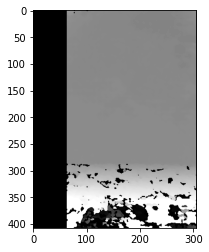

In [ ]:
win_size = 7 
min_disp = -1
max_disp = 63 
num_disp = max_disp - min_disp 
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
	numDisparities = num_disp,
	blockSize = 5, 
	uniquenessRatio = 10, 
	speckleWindowSize = 5, 
	speckleRange = 100, 
	disp12MaxDiff = 25, 
	P1 = 8*3*win_size**2,
	P2 =32*3*win_size**2) 

#Compute disparity map
print ("\nComputing the disparity  map...")
bg_disparity_map = stereo.compute(bg_rectifiedL, bg_rectifiedR)
bg_disparity_map = cv2.normalize(bg_disparity_map, None, alpha=0, beta=255,
                              norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.imshow(bg_disparity_map, 'gray')
plt.show()

#First method to subtract the background
Absolute difference between background image and object image.
Then median filter with filter size = 5

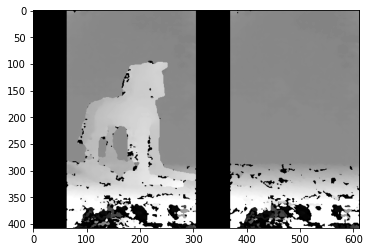

In [ ]:
aligned = np.hstack((disparity_map, bg_disparity_map))
plt.imshow(aligned,'gray')
plt.show()

In [ ]:
def img_absdiff (img, bg_img, threshold):
    diff = cv2.absdiff(img, bg_img)

    th = threshold #vary this value to get better results (the higher seems the better)
    imask =  diff>th

    sub = np.zeros_like(img, np.uint8)
    sub[imask] = img[imask]

    return sub

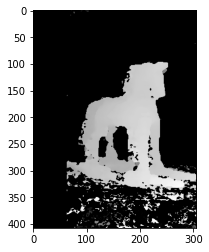

In [ ]:
sub_image = img_absdiff(disparity_map, bg_disparity_map, 2)
plt.imshow(sub_image, 'gray')
plt.show()

In [ ]:
def median_filter(image, filter_size):
    median = cv2.medianBlur(image, filter_size)
    return median

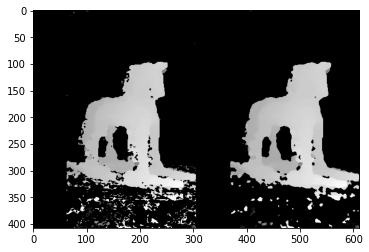

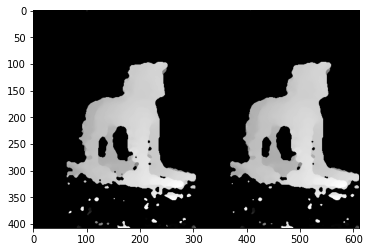

True

In [ ]:
FILTER_SIZE = 5
m1 = median_filter(sub_image,FILTER_SIZE)
disp1 = median_filter(m1,FILTER_SIZE)
m3 = median_filter(disp1,FILTER_SIZE)

r1 = np.hstack((sub_image, m1))
r2 = np.hstack((disp1, m3))
plt.imshow(r1, 'gray')
plt.show()
plt.imshow(r2, 'gray')
plt.show()
cv2.imwrite(drive_root+'final/paper_imgs/first_disp.png', disp1)

#Second method to subtract the background
Apply MOG2 background subtractor method to the two disparity maps

In [ ]:
def subtract_bg (img, bg_img):
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=50,detectShadows=True) #CAMBIA QUESTO VALORE
    _ = backSub.apply(bg_img)
    mask = backSub.apply(img)

    return mask

In [ ]:
mask = subtract_bg(disparity_map, bg_disparity_map)
sub_img = cv2.bitwise_and(disparity_map, disparity_map, None, mask)

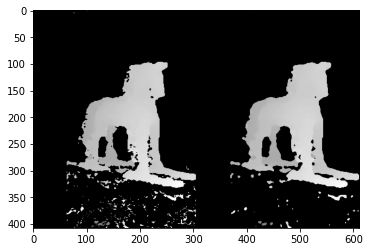

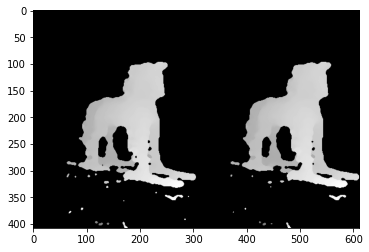

True

In [ ]:
FILTER_SIZE = 5
m1 = median_filter(sub_img,FILTER_SIZE)
disp2 = median_filter(m1,FILTER_SIZE)
m3 = median_filter(disp2,FILTER_SIZE)

r1 = np.hstack((sub_img, m1))
r2 = np.hstack((disp2, m3))
plt.imshow(r1, 'gray')
plt.show()
plt.imshow(r2, 'gray')
plt.show()
cv2.imwrite(drive_root+'final/paper_imgs/second_disp.png', disp2)

#Third method to subract the background
compute the mean of 5 images representing the object and 5 images with just the background and pass the results to the MOG2 backgorund subractor



In [ ]:
#blending multiple images for robustness
def blend_images (images):
    avg_image = images[0]
    for i in range(len(images)):
        if i == 0:
            pass
        else:
            alpha = 1.0/(i + 1)
            beta = 1.0 - alpha
            avg_image = cv2.addWeighted(images[i], alpha, avg_image, beta, 0.0)
    return avg_image

In [ ]:
obj_img = []
for i in range(1060,1065):
    this_image = cv2.imread(obj_path +"left/IMG_" + str(i) + ".JPG", 1)
    obj_img.append(this_image)
obj = blend_images(obj_img)

In [ ]:
bg_img = []
for i in range(1075,1080):
    this_image = cv2.imread(obj_path +"left/IMG_" + str(i) + ".JPG", 1)
    bg_img.append(this_image)
bg = blend_images(bg_img)

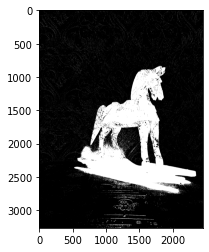

In [ ]:
mask = subtract_bg(obj, bg)
plt.imshow(mask,'gray')
plt.show()

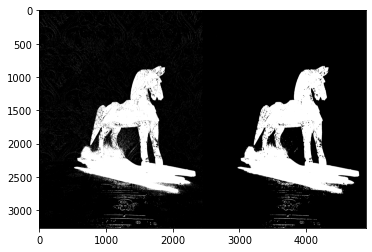

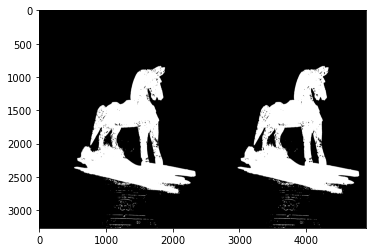

In [ ]:
FILTER_SIZE = 5
m1 = median_filter(mask,FILTER_SIZE)
m2 = median_filter(m1,FILTER_SIZE)
m3 = median_filter(m2,FILTER_SIZE)

r1 = np.hstack((mask, m1))
r2 = np.hstack((m2, m3))
plt.imshow(r1, 'gray')
plt.show()
plt.imshow(r2, 'gray')
plt.show()

In [ ]:
best_mask = downsample_image(m3, REDUCE_FACTOR)
final = cv2.bitwise_and(disparity_map,disparity_map,None,best_mask)

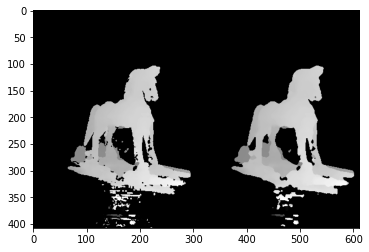

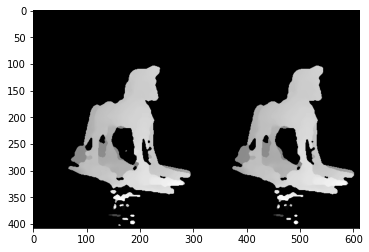

True

In [ ]:
FILTER_SIZE = 5
m1 = median_filter(final,FILTER_SIZE)
m2 = median_filter(m1,FILTER_SIZE)
disp3 = median_filter(m2,FILTER_SIZE)

r1 = np.hstack((final, m1))
r2 = np.hstack((m2, disp3))
plt.imshow(r1, 'gray')
plt.show()
plt.imshow(r2, 'gray')
plt.show()
cv2.imwrite(drive_root+'final/paper_imgs/third_disp.png', disp3)

#Deep Learning Disparity map


MIDDLEBURY

In [ ]:
m = cv2.imread(drive_root+"final/paper_imgs/out.png")
mdl = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)

bg = cv2.imread(drive_root+"final/mdl_bg.png")
mdl_bg = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)

In [ ]:
mask = subtract_bg(mdl, mdl_bg)
sub_img = cv2.bitwise_and(mdl,mdl,None,mask)

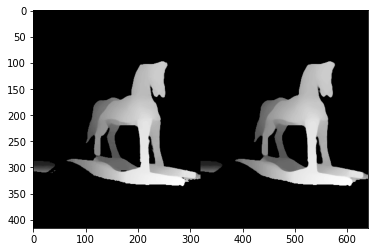

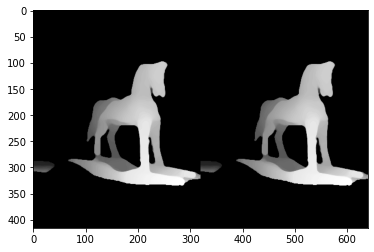

In [ ]:
FILTER_SIZE = 5
m1 = median_filter(sub_img,FILTER_SIZE)
m2 = median_filter(m1,FILTER_SIZE)
disp4 = median_filter(m2,FILTER_SIZE)

r1 = np.hstack((sub_img, m1))
r2 = np.hstack((m2, disp4))
plt.imshow(r1, 'gray')
plt.show()
plt.imshow(r2, 'gray')
plt.show()
#cv2.imwrite(drive_root+'final/paper_imgs/dl_disp_map.png', m2)

##Different background subtraction approacches 

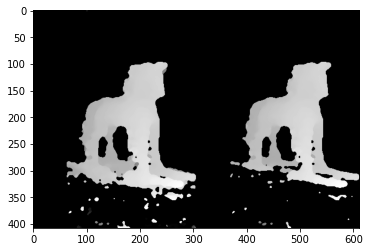

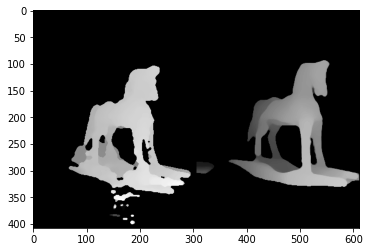

True

In [ ]:
r1 = np.hstack((disp1, disp2))
r2 = np.hstack((disp3, disp4[4:412,8:314]))
r3 = np.vstack((r1,r2))
plt.imshow(r1, 'gray')
plt.show()
plt.imshow(r2, 'gray')
plt.show()
cv2.imwrite(drive_root+'final/paper_imgs/dl_disp.png', disp4[4:412,8:314])